In [242]:
# tools for handling files
import sys
import os

# pandas/numpy for handling data
import pandas as pd
import numpy as np

# seaborn/matplotlib for graphing
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statistics import mean 
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats

# for reading individual telomere length data from files
from ast import literal_eval

# for grabbing individual cells
import more_itertools

# my module containing functions for handling/visualizing/analyzing telomere length/chr rearrangement data
import telomere_methods_rad_patient as trp

# machine learning 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, auc, accuracy_score, r2_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# setting darkgrid style for seaborn figures
sns.set_style(style="darkgrid",rc= {'patch.edgecolor': 'black'})

In [257]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Machine Learning (ML) - predicting mean telomere length post-therapy (4 C) using pre-therapy individual telos

## Loading/merging data for ML

In [87]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [88]:
# cleaning & combing data; retaining features of interest
telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, all_patients_df=all_patients_df)
print(telo_data.shape)
telo_data.head()

(128800, 4)


,patient id,timepoint,individual telomeres,4 C telo means
0,1,1 non irrad,141.486033,99.346299
1,1,2 irrad @ 4 Gy,52.792768,99.346299
2,1,1 non irrad,96.082838,99.346299
3,1,2 irrad @ 4 Gy,100.306259,99.346299
4,1,1 non irrad,69.687151,99.346299


## Train/test split 

In [89]:
telo_test = telo_data.copy()
train_set, test_set = train_test_split(telo_test, test_size=0.2, shuffle=True, stratify=telo_test[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [90]:
clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [91]:
model = XGBRegressor(n_estimators=200, max_depth=7, learning_rate=0.2,
                     objective ='reg:squarederror', random_state=0)

xgb_pipe = Pipeline([('XGB', model)
                    ])

full_pipe = Pipeline([('clean_process', clean_process_pipe),
                      ('model', model)
                     ])

## Cleaning data with pipeline

In [92]:
train_clean = train_set.copy()
test_clean = test_set.copy()

train_clean = clean_process_pipe.fit_transform(train_clean)
test_clean = clean_process_pipe.fit_transform(test_clean)

## Random GridSearch for pipeline/model params

In [10]:
# #XGBoost params for random grid search
# param_grid = {'XGB__max_depth': [3, 7, 9],
#               'XGB__learning_rate': [0.05, 0.1]}

# X_train = train_clean[['individual telomeres', 'timepoint_1']].copy()
# y_train = train_clean['4 C telo means'].copy()

# folds = KFold(5, shuffle=True, random_state=0)
# df_results, best_estimator = trp.grid_search(X_train, y_train, xgb_pipe, param_grid, 
#                                           scoring='neg_mean_absolute_error', cv=folds, n_iter=2)
# print(best_estimator)

## Bayesian Optimization

In [11]:
# target = '4 C telo means'
# features = [col for col in train_clean if col != target and col != 'patient id']

# X_train = train_clean[features].copy()
# y_train = train_clean[target].copy()

In [12]:
# pbounds = {
#     'learning_rate': (0.1, 0.2),
#     'n_estimators': (100, 200),
#     'max_depth': (3, 30),
#     'subsample': (.80, 1.0),  
#     'colsample': (1.0, 1.0),  # Change for datasets with lots of features
#     'gamma': (0, 1)}

# def xgboost_hyper_param(learning_rate, n_estimators, max_depth,
#                         subsample, colsample, gamma):
 
#     max_depth = int(max_depth)
#     n_estimators = int(n_estimators)
 
#     clf = XGBRegressor(max_depth=max_depth,
#                        learning_rate=learning_rate,
#                        n_estimators=n_estimators,
#                        gamma=gamma, objective='reg:squarederror')
    
#     return np.mean(cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error'))
 
# optimizer = BayesianOptimization(
#     f=xgboost_hyper_param,
#     pbounds=pbounds,
#     random_state=1,)

# optimizer.maximize(init_points=10, n_iter=5)

In [13]:
# bayesian optimized model
bo_model = XGBRegressor(n_estimators=260, max_depth=17, learning_rate=0.25,
                       objective ='reg:squarederror', random_state=0, subsample=.9,
                       gamma=1.7)

## Cross validation; MAE & R2 score 

In [94]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_xgb_model, telo_row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                                    model=model, cv=5)

MAE per CV fold: 
[3.23573765 3.17309376 3.08256509 3.20357854 3.25276603] 

MEAN of MAE all folds: 3.189548214285195
STD of MAE all folds: 0.0600715319146209

MAE of predict_y_test & y_test: 3.1701672333162967
R2 between predict_y_test & y_test: 0.8887026765855984


In [244]:
y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_xgb_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 2.9388135395793404
R2 predicted vs. actual 4 C telo means: 0.9299645551912994


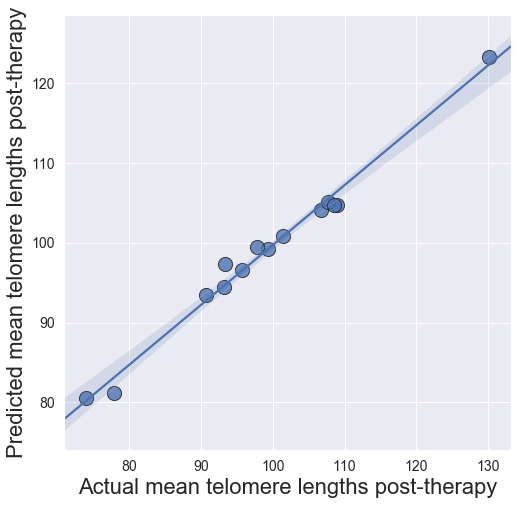

In [241]:
plt.figure(figsize=(8,8))
ax = sns.regplot(x=y_true_list, y=y_predict_list, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual mean telomere lengths post-therapy', fontsize=22)
ax.set_ylabel('Predicted mean telomere lengths post-therapy', fontsize=22)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 1', fontsize=22, weight='bold')
# plt.savefig('predicting mean telos 3 months post.png')

## Testing if linear regression can predict 4C mean telos using individual telos

In [48]:
lr_model = LinearRegression(normalize=True)
lr_pipe = Pipeline([('lr_model', lr_model)
                   ])

In [52]:
# predicting mean telo telo post-therapy (4 C) using individual telos
fit_lr_model, row = trp.cv_score_fit_mae_test(train_set=train_clean, test_set=test_clean,
                                              model=lr_model, cv=5)

MAE per CV fold: 
[9.51714781 9.58245514 9.50641152 9.47809622 9.51959829] 

MEAN of MAE all folds: 9.520741796574011
STD of MAE all folds: 0.03419579980410117

MAE of predict_y_test & y_test: 9.492456614132134
R2 between predict_y_test & y_test: 0.04830692608076359


In [245]:
lr_y_predict_list, y_true_list = trp.predict_target_4C_compare_actual(telo_data=telo_test, test_set=test_set, 
                                     model=fit_lr_model, target='4 C telo means',
                                     clean_process_pipe=clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C telo means: 9.273390637627383
R2 predicted vs. actual 4 C telo means: 0.0790613113280434


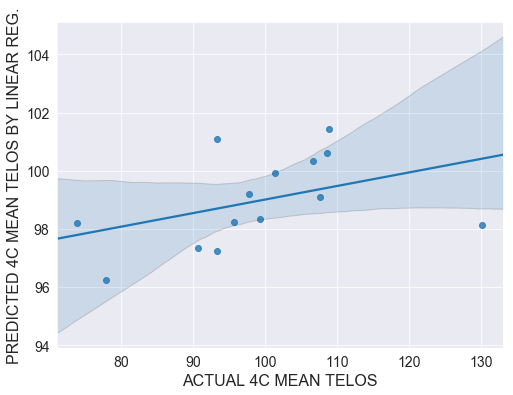

In [54]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true_list, y=lr_y_predict_list)
ax.set_xlabel('ACTUAL 4C MEAN TELOS', fontsize=16)
ax.set_ylabel('PREDICTED 4C MEAN TELOS BY LINEAR REG.', fontsize=16)
ax.tick_params(labelsize=14)

# Machine Learning - exploring predictions of #s of short telomeres post-therapy

## Loading/merging data for ML

In [63]:
exploded_telos_all_patients_df = pd.read_csv('../compiled patient data csv files/exploded_telos_all_patients_df.csv')
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')

In [64]:
# cleaning & combing data; retaining features of interest
quartile_telo_data = trp.combine_data(exploded_telos=exploded_telos_all_patients_df, 
                                      all_patients_df=all_patients_df,
                                      prediction_objective='4 C # short telos from individual telos')
quartile_telo_data.head()

,patient id,timepoint,individual telomeres,4 C # short telos
0,1,1 non irrad,141.486033,372
1,1,2 irrad @ 4 Gy,52.792768,372
2,1,1 non irrad,96.082838,372
3,1,2 irrad @ 4 Gy,100.306259,372
4,1,1 non irrad,69.687151,372


## Train/test split 

In [96]:
quartile_telo_test = quartile_telo_data.copy()

y = quartile_telo_test[['4 C # short telos']]
X = quartile_telo_test.drop(['4 C # short telos'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y)

q_train_set = pd.concat([X_train, y_train], axis=1).reset_index(drop=True)
q_test_set = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)

## Initializing cleaning/model pipelines

In [97]:
q_clean_process_pipe = Pipeline([('features', trp.make_features(make_log_target=False)), 
                               ('dummies', trp.make_dummies(drop_first=True)),
                               ('cleaner', trp.clean_data(drop_patient_id=True))
                              ])

In [98]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
q_model = XGBRegressor(n_estimators=200, max_depth=6, learning_rate=0.2,
                       objective='reg:squarederror', random_state=0, gamma=3)

q_xgb_pipe = Pipeline([('XGB', model)
                      ])

q_full_pipe = Pipeline([('clean_process', q_clean_process_pipe),
                        ('model', q_model)
                       ])

## Cleaning/modeling data with pipeline

In [99]:
q_train_clean = q_train_set.copy()
q_test_clean = q_test_set.copy()

q_train_clean = q_clean_process_pipe.fit_transform(q_train_clean)
q_test_clean = q_clean_process_pipe.fit_transform(q_test_clean)

## Cross validation; MAE & R2 score when predicting # of short telomeres post-therapy (4 C)

In [100]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data
# w/ model, predict y_test from X_test; score model by MAE/R2 - return model

q_fit_xgb_model, short_telos_row = trp.cv_score_fit_mae_test(train_set=q_train_clean, test_set=q_test_clean,
                                                             model=q_model, cv=5, 
                                                             target='4 C # short telos')

MAE per CV fold: 
[235.88754201 229.6968635  235.5287428  227.85628419 231.1107529 ] 

MEAN of MAE all folds: 232.01603708045087
STD of MAE all folds: 3.1883946286107

MAE of predict_y_test & y_test: 234.30544931992242
R2 between predict_y_test & y_test: 0.8156439458465545


In [246]:
q_y_xgb_predict, q_y_true = trp.predict_target_4C_compare_actual(telo_data=quartile_telo_data, test_set=q_test_set, 
                                                                 model=q_fit_xgb_model, target='4 C # short telos',
                                                                 clean_process_pipe=q_clean_process_pipe, verbose=False)

MAE predicted vs. actual 4 C # short telos: 214.5894993373326
R2 predicted vs. actual 4 C # short telos: 0.8699079747548508


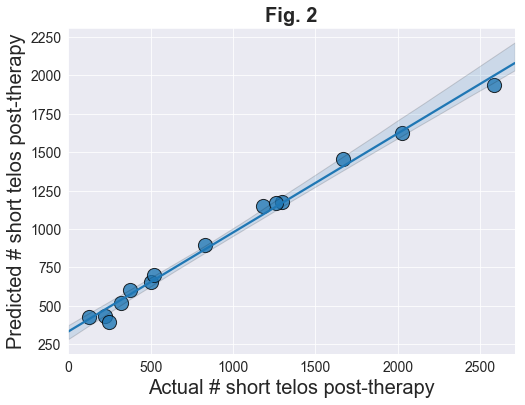

In [102]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=q_y_true, y=q_y_xgb_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # short telos post-therapy', fontsize=20)
ax.set_ylabel('Predicted # short telos post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

# Machine Learning - exploring predictions of chromosome rearrangements

## Loading data & general cleaning

In [248]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner())])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)

## Train/test split 

In [249]:
chr_train, chr_test = train_test_split(cleaned_chr_df, test_size=0.2, shuffle=True, 
                                       stratify=cleaned_chr_df[['patient id', 'timepoint']])

## Initializing cleaning/model pipelines

In [250]:
features = ['# inversions']
target = '# inversions'

make_new_features_target = Pipeline([('make features', trp.make_chr_features(combine_inversions=False, bool_features=False,
                                                                             features=features)),
                                     ('make target merge', trp.make_target_merge(target=target, features=features))
                                    ])

In [251]:
# initialize XGBoost model & pipeline for hyperparams gridsearch
chr_model = XGBRegressor(n_estimators=200, max_depth=15, learning_rate=0.1,
                         objective='reg:squarederror',
                         random_state=0,
                        )

chr_xgb_pipe = Pipeline([('XGB', chr_model)
                        ])

chr_full_pipe = Pipeline([('make ftr target', make_new_features_target),
                          ('model', chr_model)
                         ])

## Cleaning/modeling data with pipeline

In [252]:
cleaned_chr_train = chr_train.copy()
cleaned_chr_test = chr_test.copy()

cleaned_chr_train = make_new_features_target.fit_transform(cleaned_chr_train)
cleaned_chr_test = make_new_features_target.fit_transform(cleaned_chr_test)

In [253]:
cleaned_chr_train.head()

,patient id,# inversions,4 C # inversions,timepoint_2 irrad @ 4 Gy
0,15,1,0.458333,1
1,15,1,0.458333,0
2,15,0,0.458333,0
3,15,0,0.458333,0
5,15,0,0.458333,0


## Cross validation; MAE & R2 score when predicting # of chr aberrations post-therapy (4 C)

In [132]:
bo_model = XGBRegressor(n_estimators=300, 
                        max_depth=10, 
                        learning_rate=0.2,
                        objective='reg:squarederror',
#                         colsample=.8897,
#                         gamma=3.185,
                        random_state=0,
                        )

In [254]:
# score model by cross validation, 5 folds, on X/y_train data 
# fit model on train data; w/ model, predict y_test from X_test; score model by MAE/R2 - return model
chr_fit_xgb_model, row = trp.cv_score_fit_mae_test(train_set=cleaned_chr_train, test_set=cleaned_chr_test,
                                              model=chr_model, cv=5, target='4 C # inversions')

MAE per CV fold: 
[0.03822969 0.04734456 0.11346747 0.11913558 0.16363418] 

MEAN of MAE all folds: 0.09636229555405193
STD of MAE all folds: 0.04715687468122467

MAE of predict_y_test & y_test: 0.232005834402073
R2 between predict_y_test & y_test: -0.10153338565314418


In [255]:
chr_y_predict, y_true, = trp.chr_aberr_predict_target_4C_compare_actual(cleaned_unsplit_chr_data=cleaned_chr_df, 
                                                                        cleaned_test_set=cleaned_chr_test, 
                                                                        model=chr_fit_xgb_model, target='4 C # inversions',
                                                                        clean_process_pipe=make_new_features_target, verbose=False)

MAE predicted vs. actual 4 C # inversions: 0.08499339109375378
R2 predicted vs. actual 4 C # inversions: -0.026725170086986827


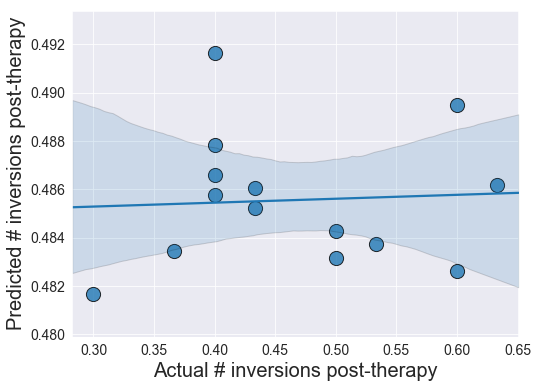

In [116]:
plt.figure(figsize=(8,6))
ax = sns.regplot(x=y_true, y=chr_y_predict, scatter_kws={'s':200, 'edgecolor':'k'}, )
ax.set_xlabel('Actual # inversions post-therapy', fontsize=20)
ax.set_ylabel('Predicted # inversions post-therapy', fontsize=20)
ax.tick_params(labelsize=14)
# ax.set_title('Fig. 2', weight='bold', fontsize=20)
plt.savefig('predicting # short telos 3 months post.png')

## Looping through all aberrations for XGBoost model fitting, creating dataframes for graphing, displaying model metrics

In [258]:
features_list = [['# inversions'], ['# terminal inversions'], ['# translocations'], ['# dicentrics'],
                 ['# inversions', '# terminal inversions', '# translocations', '# dicentrics']]

           
target1_list = ['# inversions', '# terminal inversions', '# translocations', '# dicentrics',
                'aberration index']

target2_list = ['4 C # inversions', '4 C # terminal inversions', '4 C # translocations', '4 C # dicentrics',
                '4 C aberration index']

stats_df = []
stats_df, graphing_dict = trp.script_load_clean_data_ml_pipeline_loop_aberrations(features_list=features_list,
                                                                                  target1_list=target1_list,
                                                                                  target2_list=target2_list,
                                                                                  stats_df=stats_df,
                                                                                  verbose=False)

--------------------------------------------------------------------
PERFORMING CROSSFOLD VALIDATION of XGBoost model
features: ['# inversions'] ___ target: 4 C # inversions
--------------------------------------------------------------------
MAE per CV fold: 
[0.09692658 0.07416919 0.12775312 0.16596306 0.07941618] 

MEAN of MAE all folds: 0.10884562424484794
STD of MAE all folds: 0.0341482241194872

MAE of predict_y_test & y_test: 0.2620257650102888
R2 between predict_y_test & y_test: -0.017993011604833464
--------------------------------------------------------------------
PREDICTIONS of trained XGBoost model vs. actual values
features: ['# inversions'] ___ target: 4 C # inversions
--------------------------------------------------------------------
MAE predicted vs. actual 4 C # inversions: 0.08383496630759481
R2 predicted vs. actual 4 C # inversions: -0.005135401076253876


--------------------------------------------------------------------
PERFORMING CROSSFOLD VALIDATION of XGBo

## Dataframes for graphing predicted vs. actual, table of model metrics

In [174]:
graphing_df, stats_df = trp.make_graphing_df_stats_df(graphing_dict=graphing_dict, stats_df=stats_df)

In [196]:
stats_df

,Model,Features,Target,Average MAE of CV folds,Std dev of MAE of CV folds,MAE predicted vs. true,R2 predicted values vs. true
0,XGBoost,"[# inversions, timepoint_2 irrad @ 4 Gy]",4 C # inversions,0.0851,0.0421,0.2680,-0.0907
1,XGBoost,"[# terminal inversions, timepoint_2 irrad @ 4 Gy]",4 C # terminal inversions,0.0921,0.0296,0.1520,-0.0491
2,XGBoost,"[# translocations, timepoint_2 irrad @ 4 Gy]",4 C # translocations,0.0432,0.0111,0.0951,-0.0003
3,XGBoost,"[# dicentrics, timepoint_2 irrad @ 4 Gy]",4 C # dicentrics,0.1174,0.0284,0.1786,-0.0182
4,XGBoost,"[# inversions, # terminal inversions, # transl...",4 C aberration index,0.2198,0.0521,0.4543,-0.1101


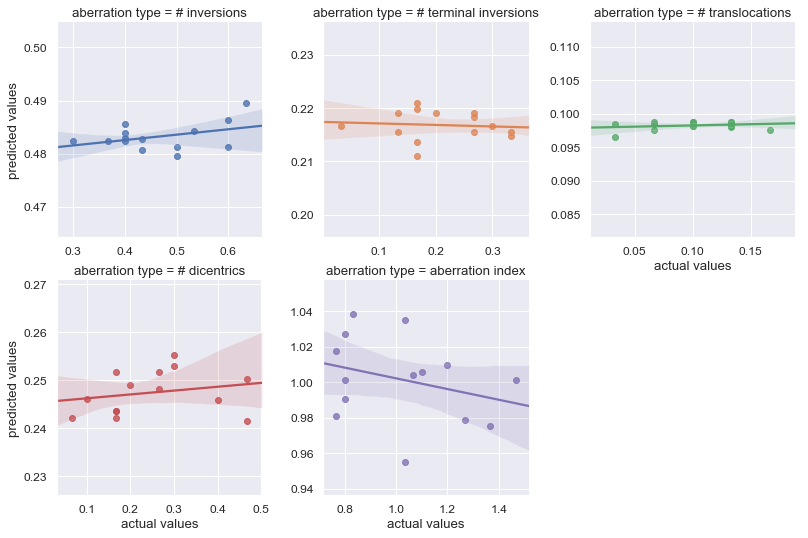

In [195]:
ax = sns.set(font_scale=1.1)
ax = sns.lmplot(x='actual values', y='predicted values', col='aberration type', hue='aberration type', 
           sharex=False, sharey=False, col_wrap=3, data=graphing_df, height=3.75)
plt.tight_layout(pad=.6)

# Clustering telomere data

## Mean telomere length (teloFISH)

In [206]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [198]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
means = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'Q1'], axis=1)

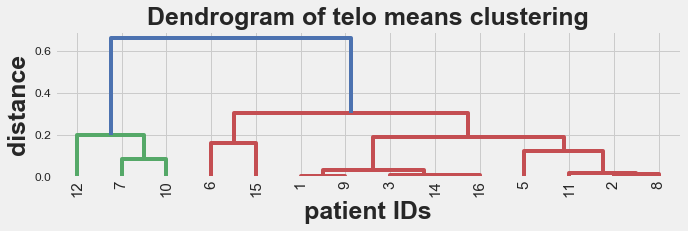

0 Cluster number 2 has 11 elements
1 Cluster number 1 has 3 elements


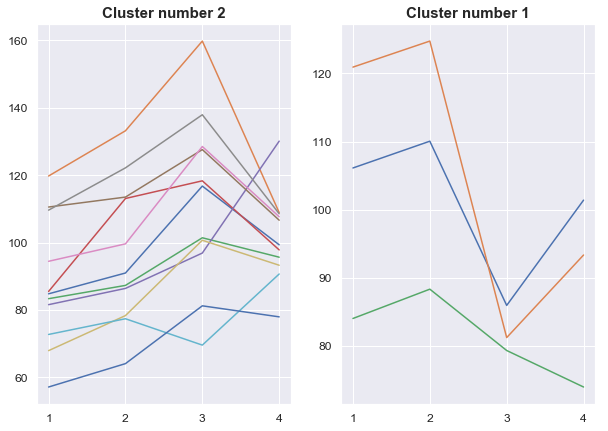

In [199]:
clustered_telos = trp.cluster_data_return_df(means, target='telo means', cut_off_n=2,
                                             metric='correlation', method='single',
                                             y_size=7)

In [218]:
# incase reloading modules is required
import importlib
%load_ext autoreload
%autoreload 

import telomere_methods_rad_patient as trp

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


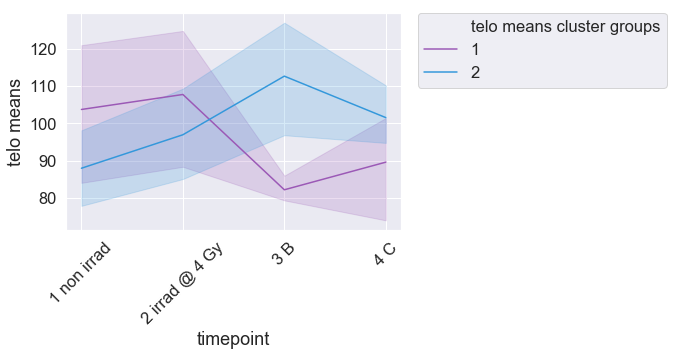

In [219]:
trp.graph_cluster_groups(clustered_telos, target='telo means', hue='telo means cluster groups')

telo means CLUSTER 1 | patient IDs: [7, 10, 12]
telo means CLUSTER 2 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]


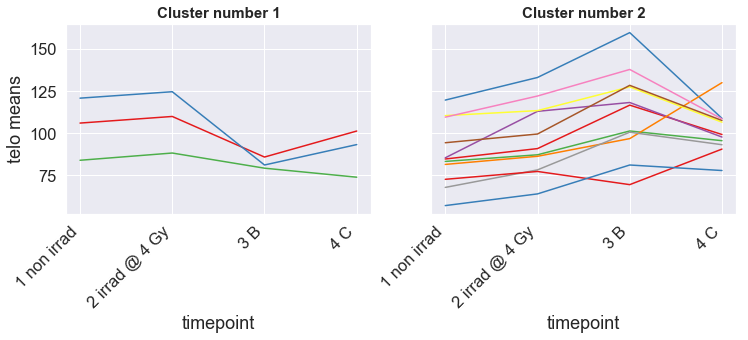

In [231]:
trp.graph_clusters_per_patient(clustered_telos, target='telo means',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Short telomeres

In [202]:
all_patients_df = pd.read_csv('../compiled patient data csv files/all_patients_df.csv')
short_telos = all_patients_df.drop(['telo data', 'chr data', 'status', 'Q2-3', 'Q4', 'telo means'], axis=1)
short_telos.rename(columns={'Q1': '# short telomeres'}, inplace=True)

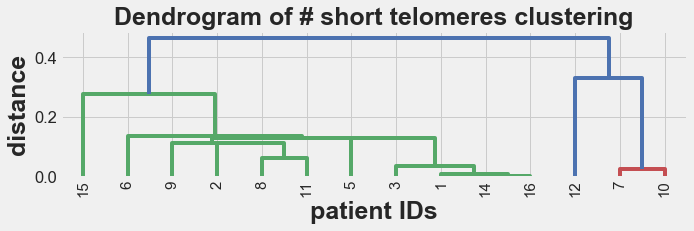

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


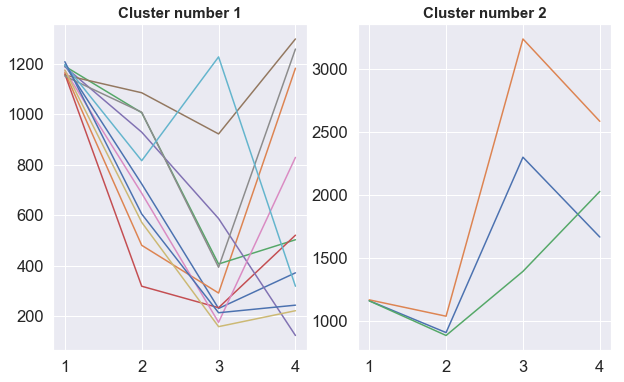

In [203]:
clustered_short_telos = trp.cluster_data_return_df(short_telos, target='# short telomeres', cut_off_n=2)

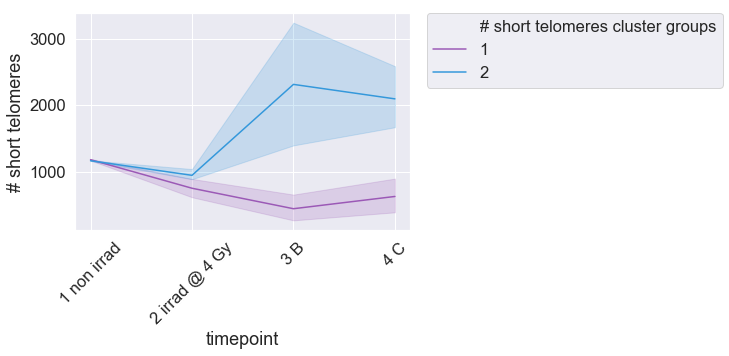

In [204]:
trp.graph_cluster_groups(clustered_short_telos, target='# short telomeres', hue='# short telomeres cluster groups')

# short telomeres CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 8, 9, 11, 14, 15, 16]
# short telomeres CLUSTER 2 | patient IDs: [7, 10, 12]


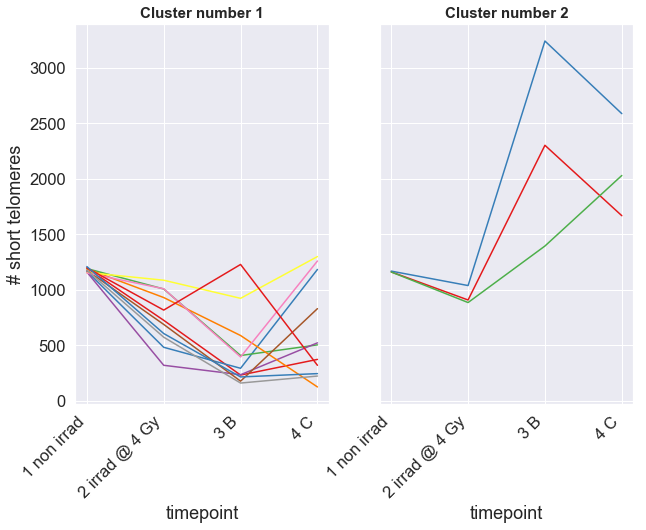

In [232]:
trp.graph_clusters_per_patient(clustered_short_telos, target='# short telomeres',
                               y_dimen=1, x_dimen=2, fsize=(10, 7))

Clustering analysis by hierarchical clustering of longitudinal changes in mean telomere length and number of short telomeres in the patients yielded 4 groups in each case, distinguishable by differential responses to radiation therapy. When patients were clustered by mean telomere length or number of short telomeres, the clustered groups differed by only one patient, suggesting strong agreement between mean telomere length and number of short telomeres for data clustering. 

## Mean telomere length (qPCR)

In [223]:
all_qPCR_df = pd.read_csv('../qPCR telo data/all_qPCR_df.csv')
means_qPCR = all_qPCR_df.drop(['SEM'], axis=1)
means_qPCR['timepoint'] = means_qPCR['timepoint'].apply(lambda row: trp.encode_timepts(row))
means_qPCR.head()

,patient id,timepoint,telo means qPCR
0,1,1,2.182028
1,1,3,1.964348
2,1,4,1.749799
3,2,1,1.669445
4,2,3,1.780092


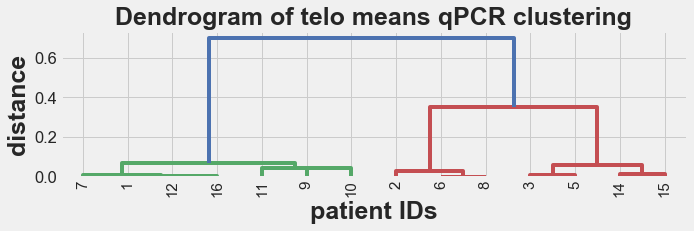

0 Cluster number 1 has 7 elements
1 Cluster number 2 has 7 elements


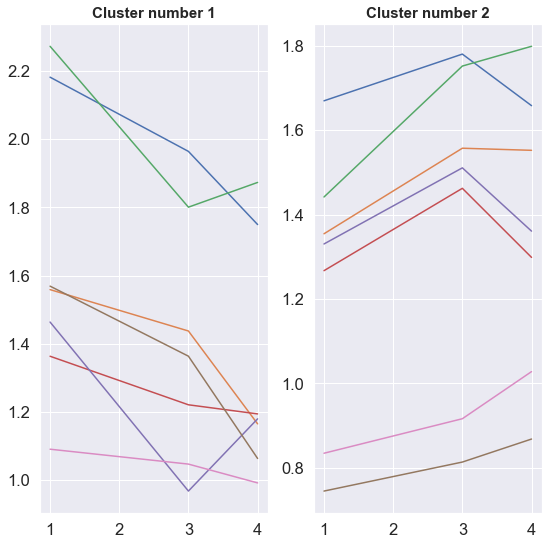

In [224]:
clustered_qPCR = trp.cluster_data_return_df(means_qPCR, target='telo means qPCR', cut_off_n=2,
                                            y_size=9, x_size=9)

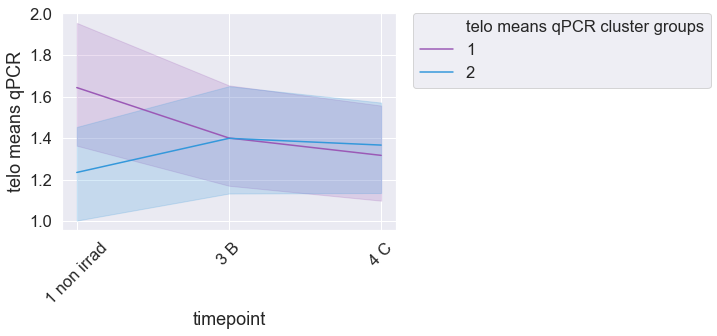

In [225]:
trp.graph_cluster_groups(clustered_qPCR, target='telo means qPCR', hue='telo means qPCR cluster groups')

# Clustering chromosome rearrangement data

In [226]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_chr = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

## Inversions

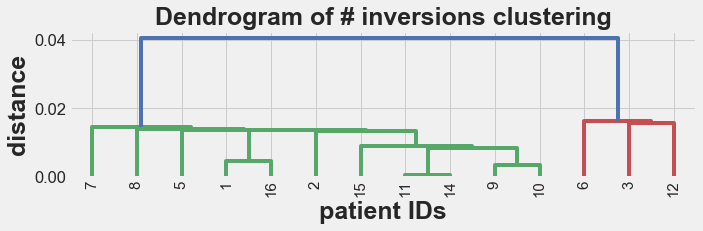

0 Cluster number 1 has 11 elements
1 Cluster number 2 has 3 elements


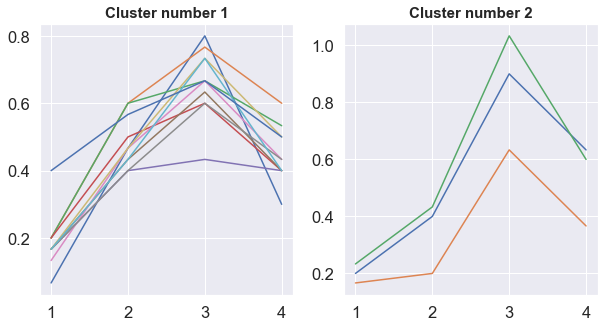

In [227]:
clustered_invs = trp.cluster_data_return_df(mean_chr, target='# inversions', cut_off_n=2,
                                            y_size=5, x_size=10)

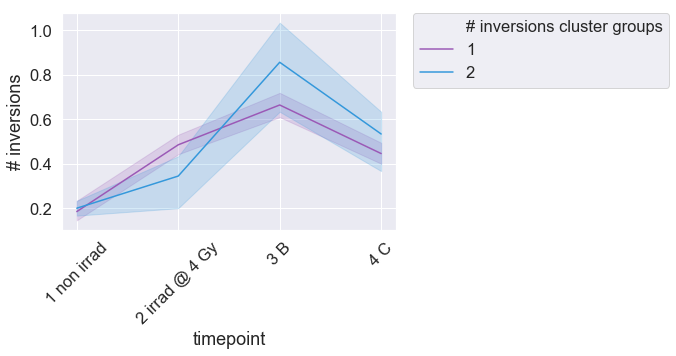

In [228]:
trp.graph_cluster_groups(clustered_invs, target='# inversions', hue='# inversions cluster groups')

# inversions CLUSTER 1 | patient IDs: [1, 2, 5, 7, 8, 9, 10, 11, 14, 15, 16]
# inversions CLUSTER 2 | patient IDs: [3, 6, 12]


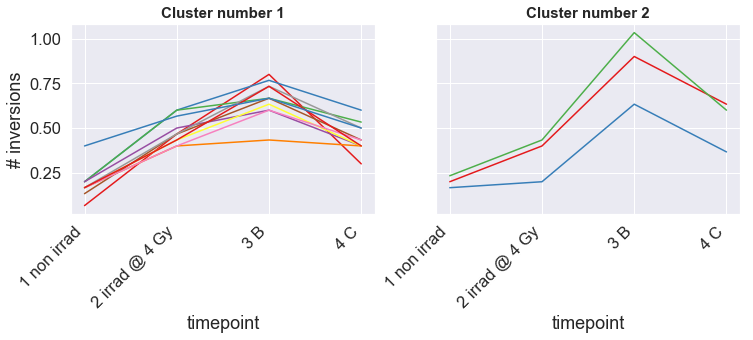

In [229]:
trp.graph_clusters_per_patient(clustered_invs, target='# inversions',
                               y_dimen=1, x_dimen=2,
                               fsize=(12,3.5))

## Dicentrics

In [233]:
all_chr_aberr_df = pd.read_csv('../compiled patient data csv files/all_chr_aberr_df.csv')

general_cleaner = Pipeline([('cleaner', trp.general_chr_aberr_cleaner(drop_what_timepoint=False))])
cleaned_chr_df = general_cleaner.fit_transform(all_chr_aberr_df)
mean_dicent = cleaned_chr_df.groupby(['patient id', 'timepoint']).agg('mean').reset_index()

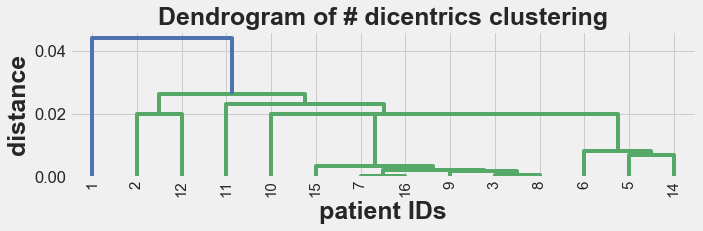

0 Cluster number 1 has 14 elements


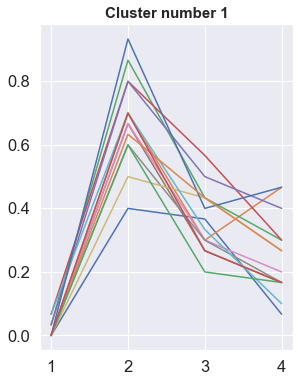

In [236]:
clustered_dicent = trp.cluster_data_return_df(mean_dicent, target='# dicentrics', cut_off_n=1)

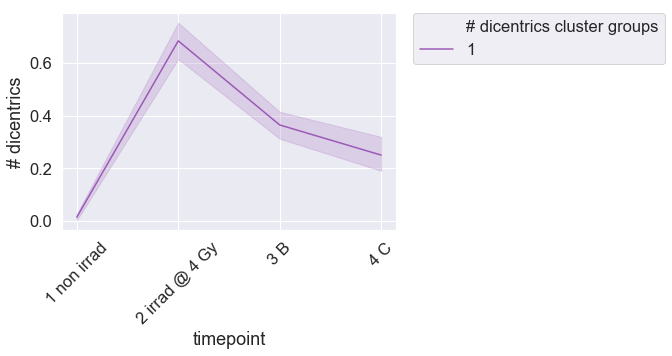

In [237]:
trp.graph_cluster_groups(clustered_dicent, target='# dicentrics', hue='# dicentrics cluster groups')

# dicentrics CLUSTER 1 | patient IDs: [1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16]


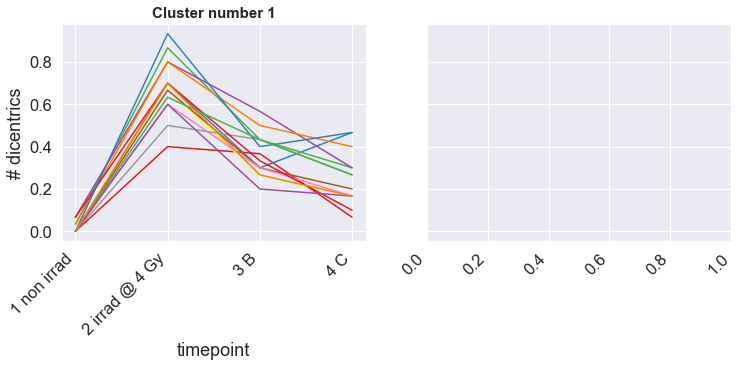

In [239]:
trp.graph_clusters_per_patient(clustered_dicent, target='# dicentrics', 
                               y_dimen=1, x_dimen=2, fsize=(12,4))

In [ ]:
chr_aberr = [col for col in mean_chr.columns if col != 'patient id' and col != 'timepoint']

for target in chr_aberr:
    clustered = trp.cluster_data_return_df(mean_chr, target=target, cut_off_n=4)
    trp.graph_cluster_groups(clustered, target=target, hue=f'{target} cluster groups')
    trp.graph_clusters_per_patient(clustered, target=target,
                                   y_dimen=2, x_dimen=2,
                                   fsize=(12,3.5))